# Feature selection tutorial

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
from sklearn.model_selection import train_test_split
from tcrpeg.classification import classification
from sklearn.utils import shuffle




In [4]:
# Add autoreload for easier development
%load_ext autoreload
%autoreload 2
from tcrpeg_toolkit.p_infer_model_evaluation import PinferCalculation
from tcrpeg.evaluate import evaluation
from tcrpeg.TCRpeg import TCRpeg
from tcrpeg_toolkit.umap_generator import UMAPGenerator

/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#write a loop to loop over all models and calculate the p_infer

# List all models in the directory
files_models = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/models/')
# Filter for carto 27 files
models = [i for i in files_models if '-27' in i]

# List all embeddings files in the directory
files_embeddings = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/')
# Filter for carto 27 files
embeddings = [i for i in files_embeddings if '-27' in i]

# List all data files
files_data = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/data/')
#filter for carto 27
data = [i for i in files_data if '27' in i]

#iterate over each model, embedding and data file and apply PinferCalculation function

for model in models:
    model_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/models/' + model
    name_models = os.path.basename(model_file).split('.pth')[0]
    
    output_dir = '/Users/vanessamhanna/Nextcloud/TCRpeg/'
    
    for embedding in embeddings:
        embedding_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/' + embedding
        name_embeddings = os.path.basename(embedding_file).split('_aa.txt')[0]

        if name_models == name_embeddings:
            for data_file in data:
                sequence_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/data/' + data_file
            
                pop_data = os.path.basename(sequence_file).split('-')[2]
                pop_models = os.path.basename(model_file).split('-')[2]
                

                if pop_data == pop_models:
                    p_infer_model = PinferCalculation(model_file=model_file,
                            embedding_file=embedding_file,
                            sequence_file=sequence_file,
                            output_dir=output_dir)
        
                    p_infer_model.run(hidden_size=128, num_layers=5)

In [105]:
# read structured array
# structured_data = process_numpy_files('/Users/vanessamhanna/Nextcloud/TCRpeg/model_evaluation/BLN-27-amTregs-TRB/', use_structured_array=False)
path = '/Users/vanessamhanna/Nextcloud/TCRpeg/model_evaluation/'

# Initialize final lists to collect data from all folders
sequence_final=[]
pinfer_final = []
sample_ids_final=[]
model_id_final=[]

# Iterate over each folder in the specified directory
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
            # Initialize lists to collect data from the current folder
            sequence_list = []
            pinfer_list = []
            sample_ids = []
            model_id = []
            # Iterate over each file in the current folder
            for file_name in os.listdir(folder_path):
                    if file_name.endswith('.npy'):
                        file_path = os.path.join(path, folder, file_name)
                        sample_name = file_name.split('-TRB_structured_pinfer')[0]
                        data= np.load(file_path)
                        sequence_list.extend(data['sequence'])
                        pinfer_list.extend(data['pinfer'])
                        sample_ids.extend(np.repeat(sample_name, len(data['sequence'])))
                        model_id.extend(np.repeat(folder, len(data['sequence'])))
                        
            # Append the collected data from the current folder to the final lists
            sequence_final.extend(sequence_list)
            pinfer_final.extend(pinfer_list)
            sample_ids_final.extend(sample_ids)
            model_id_final.extend(model_id)

# Define the dtype for the structured array
dtype = [('sample_id', 'U50'), ('model_id', 'U50'), ('sequence', 'U50'), ('pinfer', 'f4')]

# Create the structured array with the collected data
structured_array = np.array(list(zip(sample_ids_final, model_id_final, sequence_final, pinfer_final)), dtype=dtype)

# Print the structured array
print(structured_array)

[('SPL-27-nTregs', 'ILN-27-nTregs-TRB', 'CAAARGAETLYF', 1.6074548e-05)
 ('SPL-27-nTregs', 'ILN-27-nTregs-TRB', 'CAADGGDSYEQYF', 1.9823678e-06)
 ('SPL-27-nTregs', 'ILN-27-nTregs-TRB', 'CAAERLGNTGQLYF', 6.2499383e-09)
 ... ('PLN-27-nTregs', 'PALN-27-nTregs-TRB', 'WEAYNSPLYF', 2.2859270e-08)
 ('PLN-27-nTregs', 'PALN-27-nTregs-TRB', 'WSNERLFF', 3.8061216e-06)
 ('PLN-27-nTregs', 'PALN-27-nTregs-TRB', 'YASSPTGGQNTLYF', 4.0269956e-06)]


In [106]:
df = pd.DataFrame(structured_array)

# Save the DataFrame to a CSV file
# df.to_csv('/Users/vanessamhanna/Nextcloud/TCRpeg/analysis/structured_data_signature_27.csv', index=False)


In [107]:
#filter df
filtered_df = df[~df['sample_id'].str.contains('SPL')]


In [108]:
lists_f= []
for i in filtered_df['sample_id'].unique():
    data_d = filtered_df[filtered_df['sample_id']==i]
    data_d = data_d.pivot_table(index=['sample_id', 'sequence'], columns='model_id', values='pinfer', aggfunc='first').reset_index()
    data_d.columns.name = None
    data_d = data_d.reset_index(drop=True)
    check_col = i + '-TRB'
    
    def check_row(row):
            check_value = row[check_col]
            other_values = row.drop(labels=['sample_id', 'sequence', check_col]).values
            return np.where(check_value > np.max(other_values), 'signature', 'non_signature')
  
    data_d['result'] = data_d.apply(check_row, axis=1)
    lists_f.append(data_d[['sample_id', 'sequence', 'result']])

df_f = pd.concat(lists_f, ignore_index=True)

In [154]:
df_f['sample_id'].unique()

array(['BLN-27-nTregs', 'PALN-27-nTregs', 'ILN-27-nTregs',
       'RLN-27-nTregs', 'MLN-27-nTregs', 'PLN-27-nTregs', 'PALN-27-CD8',
       'RLN-27-CD8', 'ILN-27-CD8', 'BLN-27-CD8', 'PLN-27-CD8',
       'MLN-27-CD8', 'PLN-27-Teff', 'BLN-27-Teff', 'MLN-27-Teff',
       'PALN-27-Teff', 'RLN-27-Teff', 'ILN-27-Teff', 'ILN-27-amTregs',
       'RLN-27-amTregs', 'BLN-27-amTregs', 'PLN-27-amTregs',
       'PALN-27-amTregs', 'MLN-27-amTregs'], dtype=object)

In [19]:

# Save the DataFrame to a CSV file
df_f.to_csv('/Users/vanessamhanna/Nextcloud/TCRpeg/analysis/structured_data_signature_27.csv', index=False)


In [ ]:
#write a loop to loop over all models and calculate the p_infer

# List all models in the directory
files_models = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/models/')
# Filter for carto 27 files
models = [i for i in files_models if '-27' in i]

# List all embeddings files in the directory
files_embeddings = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/')
# Filter for carto 27 files
embeddings = [i for i in files_embeddings if '-27' in i]

#sample id
samples = df_f['sample_id'].unique()

results = {
    'sample': [],
    'auc': [],
    'aup': []
}
for sample in samples:
    print(sample)
    filtered_df = df_f[df_f['sample_id']== sample ]
    filtered_df['label'] = filtered_df['result'].apply(lambda x:1 if x=='signature' else 0)
    
    model= next((i for i in models if sample in i), None)
    model_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/models/' + model
        
    embedding= next((i for i in embeddings if sample in i),None)  
    embedding_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/' + embedding
    
    tcrp_model = TCRpeg(embedding_path=embedding_file, device='cpu', hidden_size=128, num_layers=5)
    tcrp_model.create_model(load=True, path=model_file)
    
    tcrpeg_c = classification(tcrpeg=tcrp_model,embedding_size=64*10, device='cpu') 
    
    train, test = train_test_split(filtered_df,test_size=0.2)
    x_train= train['sequence']
    x_test= test['sequence']
    y_train=train['label']
    y_test=test['label']
    # Convert pandas Series to NumPy arrays
    X_train = x_train.to_numpy()
    X_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    tcrpeg_c.train(x_train=x_train,y_train=y_train,epochs=3,batch_size=8,lr=1e-3,val_split=0.2)
    auc,aup,y_pres,y_trues = tcrpeg_c.evaluate(x_test=x_test,y_test=y_test,batch_size=100)
    
    # Store results in the dictionary
    results['sample'].append(sample)
    results['auc'].append(auc)
    results['aup'].append(aup)

# Convert the results dictionary to a DataFrame for easier analysis
results_df = pd.DataFrame(results)

In [158]:
results_df
results_df.to_csv('/Users/vanessamhanna/Nextcloud/TCRpeg/analysis/classification_27.csv', index=False)


In [ ]:
#random permutation test

# List all models in the directory
files_models = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/models/')
# Filter for carto 27 files
models = [i for i in files_models if '-27' in i]

# List all embeddings files in the directory
files_embeddings = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/')
# Filter for carto 27 files
embeddings = [i for i in files_embeddings if '-27' in i]

#sample id
samples = df_f['sample_id'].unique()
print(samples)

results = {
    'sample': [],
    'auc': [],
    'aup': []
}
for sample in samples:
    print(sample)
    filtered_df = df_f[df_f['sample_id']== sample ]
    filtered_df['label'] = filtered_df['result'].apply(lambda x:1 if x=='signature' else 0)
    
    model= next((i for i in models if sample in i), None)
    model_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/models/' + model
        
    embedding= next((i for i in embeddings if sample in i),None)  
    embedding_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/' + embedding
    
    tcrp_model = TCRpeg(embedding_path=embedding_file, device='cpu', hidden_size=128, num_layers=5)
    tcrp_model.create_model(load=True, path=model_file)
    
    tcrpeg_c = classification(tcrpeg=tcrp_model,embedding_size=64*10, device='cpu') 
    
    # Shuffle the DataFrame
    filtered_df['label'] = shuffle(filtered_df['label'].values, random_state=42)

    train, test = train_test_split(filtered_df,test_size=0.2, stratify=filtered_df['label'])
    x_train= train['sequence']
    x_test= test['sequence']
    y_train=train['label']
    y_test=test['label']
    # Convert pandas Series to NumPy arrays
    X_train = x_train.to_numpy()
    X_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    tcrpeg_c.train(x_train=x_train,y_train=y_train,epochs=3,batch_size=8,lr=1e-3,val_split=0.2)
    auc,aup,y_pres,y_trues = tcrpeg_c.evaluate(x_test=x_test,y_test=y_test,batch_size=100)
    
    # Store results in the dictionary
    results['sample'].append(sample)
    results['auc'].append(auc)
    results['aup'].append(aup)

# Convert the results dictionary to a DataFrame for easier analysis
results_df_permutation = pd.DataFrame(results)

In [159]:
results_df_permutation
results_df_permutation.to_csv('/Users/vanessamhanna/Nextcloud/TCRpeg/analysis/classification_permutation_27.csv', index=False)


In [160]:
plot = df_f[df_f['sample_id']=='PLN-27-nTregs']
# filtered_df.to_csv('/Users/vanessamhanna/Nextcloud/TCRpeg/analysis/metadata_signature_27.csv', index=True, index_label='id')

In [5]:
plot = pd.read_csv('/Users/vanessamhanna/Nextcloud/TCRpeg/analysis/metadata_signature_27.csv')

In [6]:
plot['id']=np.arange(0, len(plot))
plot

,id,sample_id,sequence,result
0,0,PLN-27-nTregs,CAAGADQNTLYF,signature
1,1,PLN-27-nTregs,CAAGISNERLFF,non_signature
2,2,PLN-27-nTregs,CAAGKNTEVFF,non_signature
3,3,PLN-27-nTregs,CAAGTRNERLFF,non_signature
4,4,PLN-27-nTregs,CACRAPSAETLYF,non_signature
...,...,...,...,...
11798,11798,PLN-27-nTregs,RTCSPTGVQDTQYF,non_signature
11799,11799,PLN-27-nTregs,SASSRQGANTGQLYF,non_signature
11800,11800,PLN-27-nTregs,WEAYNSPLYF,non_signature
11801,11801,PLN-27-nTregs,WSNERLFF,non_signature


In [7]:
sign = UMAPGenerator('/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/structured/PLN-27-nTregs-TRB_structured_embeddings.npy', metadata=plot)

INFO - Data loaded from /Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/structured/PLN-27-nTregs-TRB_structured_embeddings.npy


In [26]:
sign.run()


/opt/homebrew/Caskroom/miniconda/base/envs/tcrpeg_env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


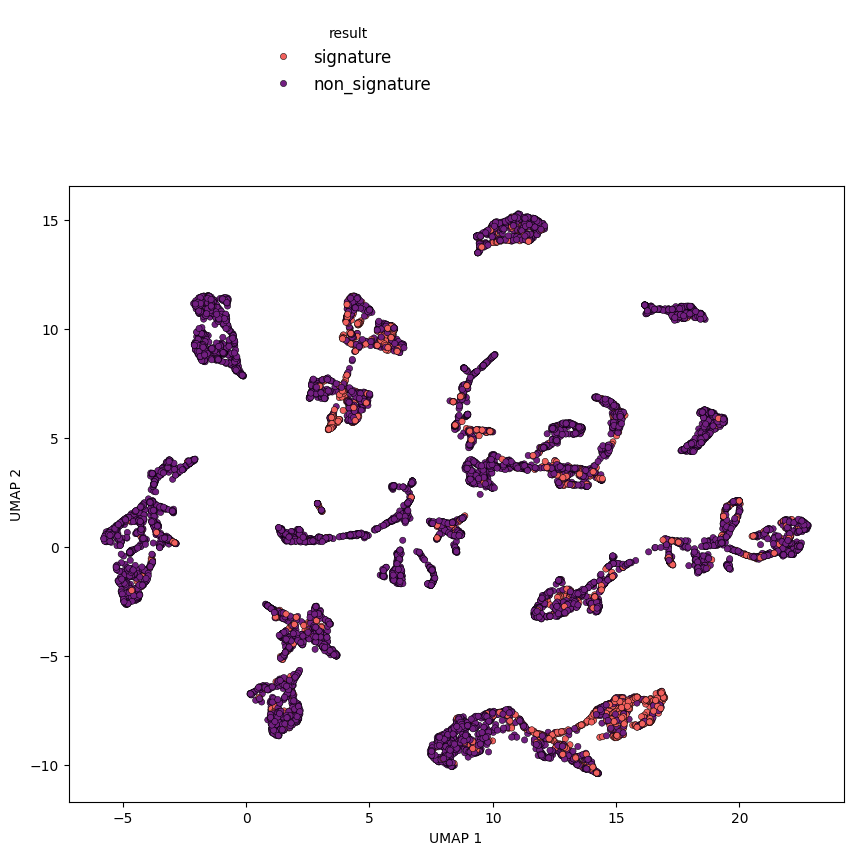

In [31]:
sign.plot_umap(hue='result', palette='magma', output_file='/Users/vanessamhanna/Nextcloud/TCRpeg/analysis/umap_signature_27.tiff'
)